# Parcial: Construcción e implementación de , Random Forest 

En este parcial podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de  Random Forest. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este parcial se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Librerias
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns


In [29]:
# Importación de librerías
%matplotlib inline

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Accord')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Accord,M_AccordEX,M_AccordEX-L,M_AccordLX,M_AccordLX-S,M_AccordSE
28,22883,2016,20969,True,False,False,False,False,False
92,19874,2015,24390,False,False,True,False,False,False
132,14000,2013,67567,True,False,False,False,False,False
136,15000,2014,79869,True,False,False,False,False,False
151,21500,2016,10240,True,False,False,False,False,False


In [30]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [32]:
# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [33]:
print(f"\nTamaño conjunto entrenamiento: {X_train.shape[0]}")
print(f"Tamaño conjunto test: {X_test.shape[0]}")


Tamaño conjunto entrenamiento: 6784
Tamaño conjunto test: 3342


### Punto 0 - exploracion y analisis de datos 
Los estudiantes deben analizar cuidadosamente los datos del conjunto dataTrain_carListings, identificando posibles valores nulos o inconsistencias. En caso de encontrar datos faltantes, deberán aplicar técnicas de imputación adecuadas para completar la información de manera coherente. Posteriormente, se espera que realicen una exploración visual mediante gráficos que permitan comprender la distribución y las relaciones entre las variables principales.


Valores nulos por columna:
✅ No hay valores nulos

Estadísticas descriptivas de variables numéricas:
          Price      Year    Mileage
count  10126.00  10126.00   10126.00
mean   15628.25   2013.08   52752.97
std     4892.12      2.99   39163.23
min     5011.00   1999.00       5.00
25%    11999.00   2012.00   25310.00
50%    15992.00   2014.00   39347.00
75%    18888.75   2015.00   73855.75
max    32000.00   2017.00  368141.00


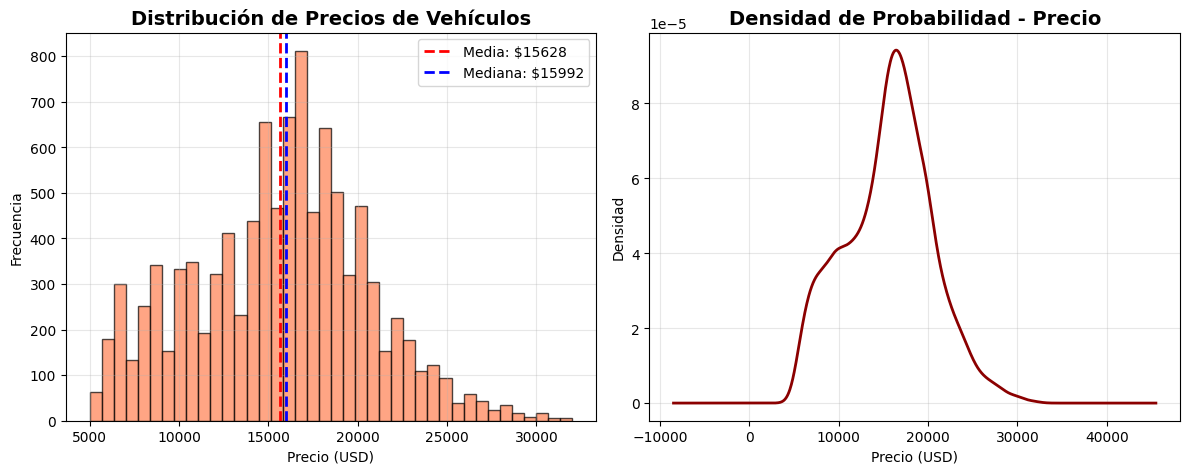

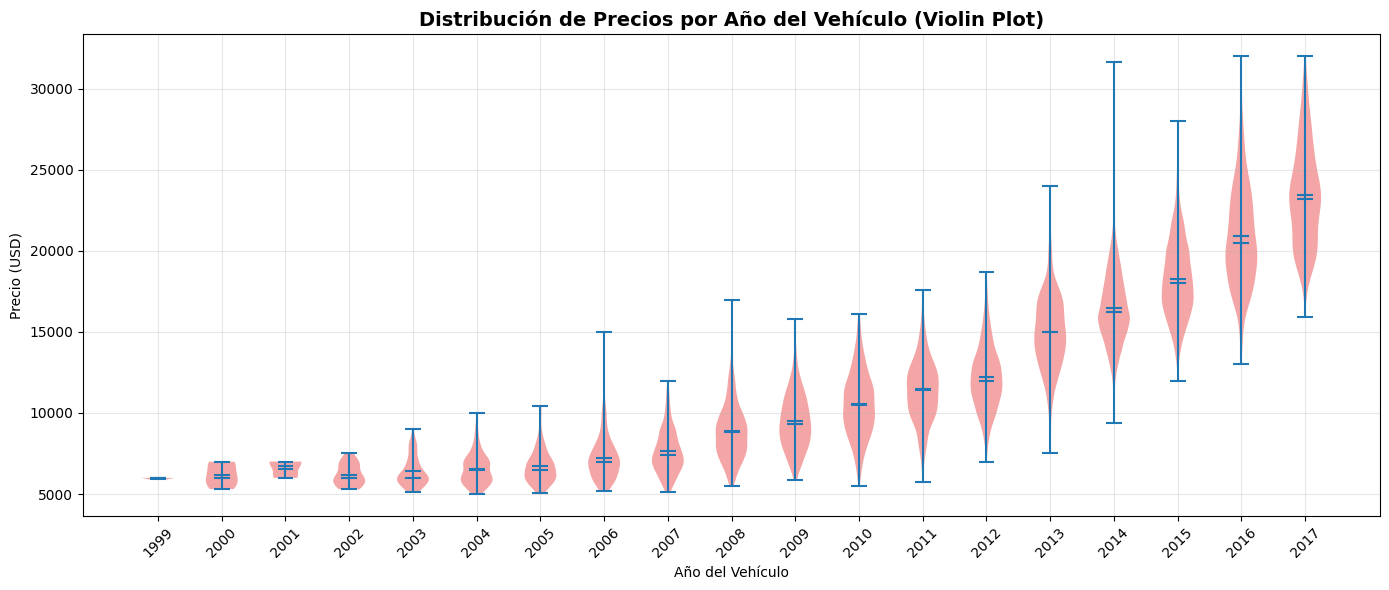

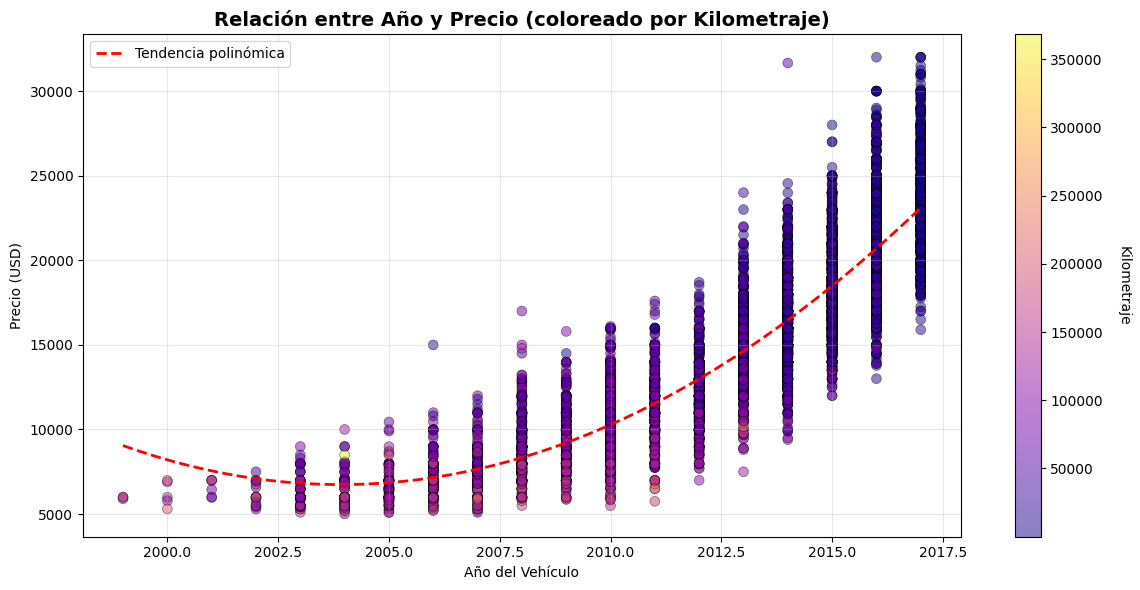

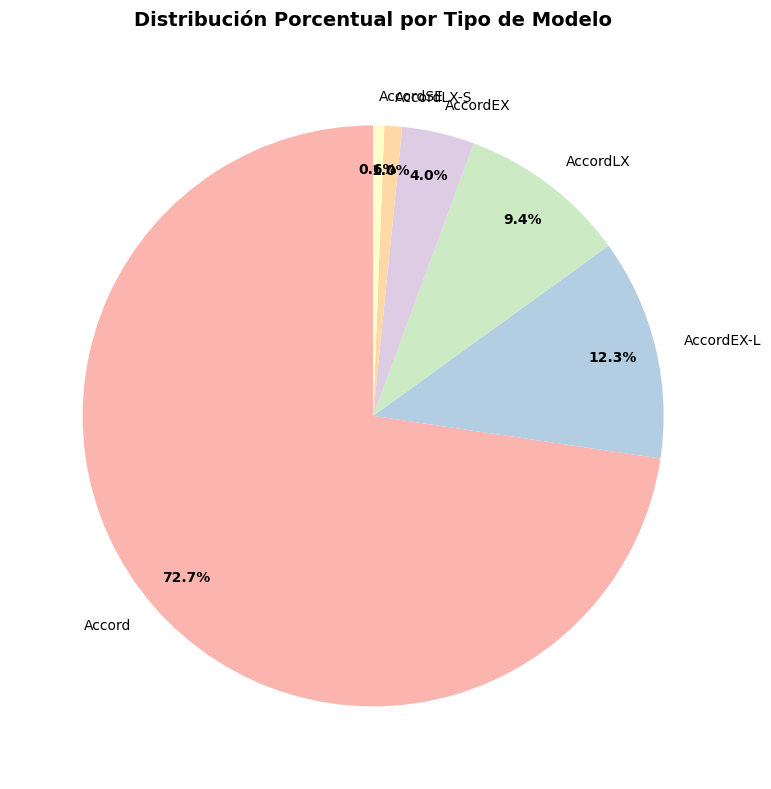

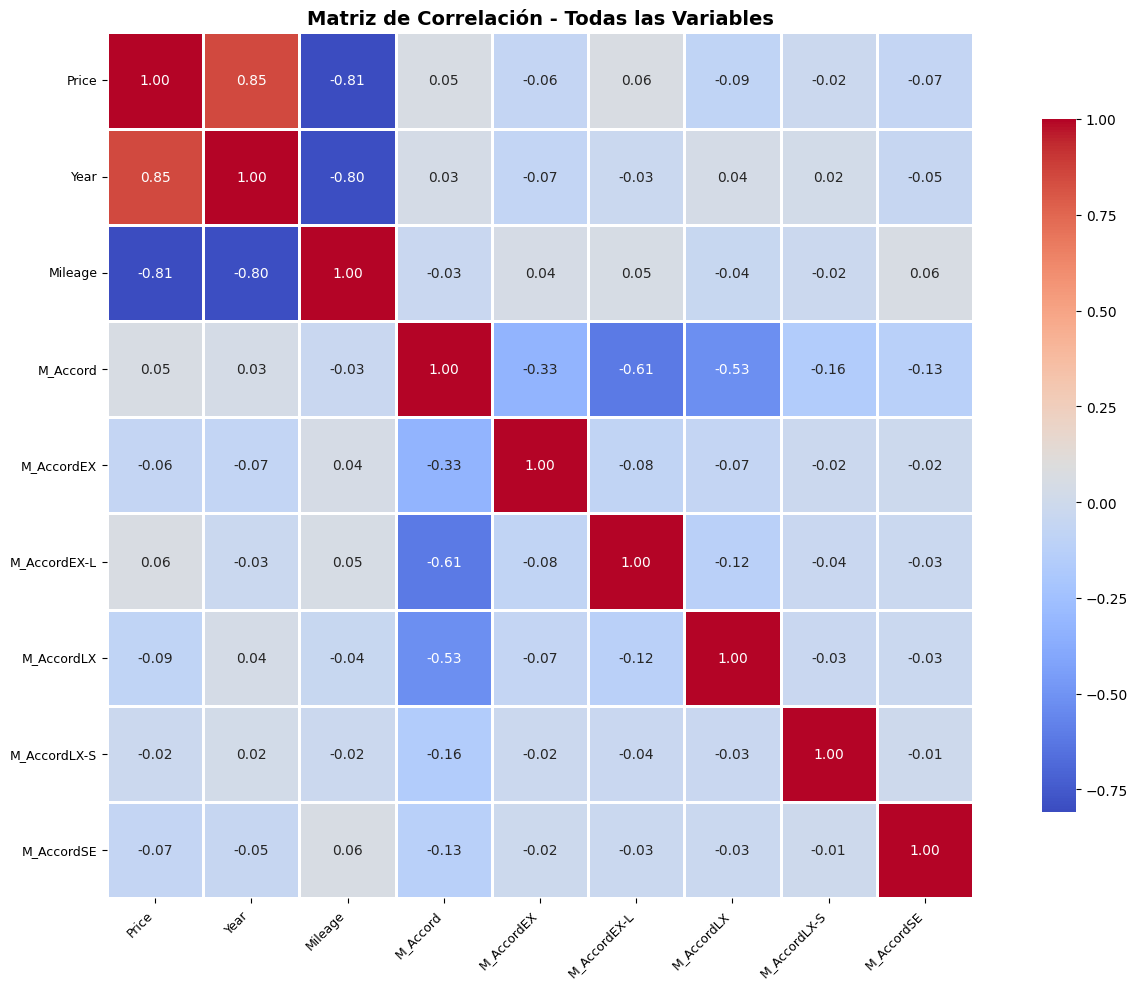

In [43]:
# Celda 0 - Exploracion y Analisis de datos

# Revisión de valores nulos
print("\nValores nulos por columna:")
nulos = data.isnull().sum()
print(nulos[nulos > 0] if nulos.sum() > 0 else "✅ No hay valores nulos")

print("\nEstadísticas descriptivas de variables numéricas:")
print(data.describe().round(2))

# Gráfico 1: Distribución de precios con KDE
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(data['Price'], bins=40, color='coral', edgecolor='black', alpha=0.7)
plt.axvline(data['Price'].mean(), color='red', linestyle='--', linewidth=2, label=f'Media: ${data["Price"].mean():.0f}')
plt.axvline(data['Price'].median(), color='blue', linestyle='--', linewidth=2, label=f'Mediana: ${data["Price"].median():.0f}')
plt.title('Distribución de Precios de Vehículos', fontsize=14, fontweight='bold')
plt.xlabel('Precio (USD)')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
data['Price'].plot(kind='kde', color='darkred', linewidth=2)
plt.title('Densidad de Probabilidad - Precio', fontsize=14, fontweight='bold')
plt.xlabel('Precio (USD)')
plt.ylabel('Densidad')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Gráfico 2: Violinplot de precios por año
plt.figure(figsize=(14, 6))
años_disponibles = sorted(data['Year'].unique())
data_plot = [data[data['Year'] == año]['Price'].values for año in años_disponibles]
parts = plt.violinplot(data_plot, positions=range(len(años_disponibles)), 
                       showmeans=True, showmedians=True)
for pc in parts['bodies']:
    pc.set_facecolor('lightcoral')
    pc.set_alpha(0.7)
plt.xticks(range(len(años_disponibles)), años_disponibles, rotation=45)
plt.title('Distribución de Precios por Año del Vehículo (Violin Plot)', fontsize=14, fontweight='bold')
plt.xlabel('Año del Vehículo')
plt.ylabel('Precio (USD)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Gráfico 3: Scatterplot con regresión (Año vs Precio)
plt.figure(figsize=(12, 6))
plt.scatter(data['Year'], data['Price'], alpha=0.5, c=data['Mileage'], 
           cmap='plasma', s=50, edgecolors='black', linewidth=0.5)
cbar = plt.colorbar()
cbar.set_label('Kilometraje', rotation=270, labelpad=20)

z = np.polyfit(data['Year'], data['Price'], 2)
p = np.poly1d(z)
x_line = np.linspace(data['Year'].min(), data['Year'].max(), 100)
plt.plot(x_line, p(x_line), "r--", linewidth=2, label='Tendencia polinómica')

plt.title('Relación entre Año y Precio (coloreado por Kilometraje)', fontsize=14, fontweight='bold')
plt.xlabel('Año del Vehículo')
plt.ylabel('Precio (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Gráfico 4: Distribución de modelos 
model_cols = [col for col in data.columns if col.startswith('Modelo_') or col.startswith('M_')]

if len(model_cols) > 0:
    model_counts = data[model_cols].sum().sort_values(ascending=False)
    model_counts = model_counts[model_counts > 0]
    
    if len(model_counts) > 0:
        plt.figure(figsize=(12, 8))
        colors = plt.cm.Pastel1(range(len(model_counts)))
        
        labels = [col.replace('Modelo_', '').replace('M_', '') for col in model_counts.index]
        
        wedges, texts, autotexts = plt.pie(
            model_counts.values, 
            labels=labels,
            autopct='%1.1f%%',
            startangle=90, 
            colors=colors,
            textprops={'fontsize': 10},
            pctdistance=0.85
        )
        
        for autotext in autotexts:
            autotext.set_color('black')
            autotext.set_fontweight('bold')
        
        plt.title('Distribución Porcentual por Tipo de Modelo', fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()
    else:
        print("No hay datos de modelos para graficar")
else:
    print("No se encontraron columnas de modelos")

# Gráfico 5: Matriz de correlación completa 
import seaborn as sns

plt.figure(figsize=(14, 10))
corr_matrix = data.corr()  

sns.heatmap(
    corr_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm',
    square=True, 
    linewidths=1,
    cbar_kws={"shrink": 0.8}
)

plt.title('Matriz de Correlación - Todas las Variables', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()

### Punto 1 - Random forest con librería

En la celda 1, usando la librería sklearn entrenen un modelo de Randon Forest para regresion  y comenten sobre el desempeño del modelo.

In [35]:
# Celda 1

model_base = RandomForestRegressor(random_state=123, n_estimators=100)
model_base.fit(X_train, y_train)


y_pred_base = model_base.predict(X_test)


mae_base = mean_absolute_error(y_test, y_pred_base)
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
r2_base = r2_score(y_test, y_pred_base)
mape_base = np.mean(np.abs((y_test - y_pred_base) / y_test)) * 100

print("\nDesempeño del modelo Random Forest base:")
print(f"  • MAE: ${mae_base:,.2f}")
print(f"  • RMSE: ${rmse_base:,.2f}")
print(f"  • MAPE: {mape_base:.2f}%")
print(f"  • R²: {r2_base:.4f}")



Desempeño del modelo Random Forest base:
  • MAE: $1,727.04
  • RMSE: $2,314.32
  • MAPE: 11.32%
  • R²: 0.7764


### Punto 2 - Calibración de parámetros Random forest

En la celda 2, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresion, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [36]:
# Celda 2
param_grid = {
    'n_estimators': [100, 200, 300],           
    'max_depth': [None, 10, 20, 30],          
    'max_features': ['sqrt', 'log2', None]     
}

print(f"Total de combinaciones a probar: {np.prod([len(v) for v in param_grid.values()])}")

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=123),
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

print("\nMejores hiperparámetros encontrados:")
for param, value in grid_search.best_params_.items():
    print(f"  • {param}: {value}")


Total de combinaciones a probar: 36
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Mejores hiperparámetros encontrados:
  • max_depth: 10
  • max_features: log2
  • n_estimators: 300


In [37]:
# Modelo optimizado
model_optimizado = grid_search.best_estimator_
y_pred_opt = model_optimizado.predict(X_test)

mae_opt = mean_absolute_error(y_test, y_pred_opt)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
r2_opt = r2_score(y_test, y_pred_opt)
mape_opt = np.mean(np.abs((y_test - y_pred_opt) / y_test)) * 100

print("\nDesempeño del modelo optimizado:")
print(f"  • MAE: ${mae_opt:,.2f} (Mejora: {((mae_base-mae_opt)/mae_base)*100:.2f}%)")
print(f"  • RMSE: ${rmse_opt:,.2f} (Mejora: {((rmse_base-rmse_opt)/rmse_base)*100:.2f}%)")
print(f"  • MAPE: {mape_opt:.2f}%")
print(f"  • R²: {r2_opt:.4f} (Mejora: {((r2_opt-r2_base)/r2_base)*100:.2f}%)")




Desempeño del modelo optimizado:
  • MAE: $1,463.06 (Mejora: 15.28%)
  • RMSE: $1,943.31 (Mejora: 16.03%)
  • MAPE: 9.73%
  • R²: 0.8424 (Mejora: 8.49%)


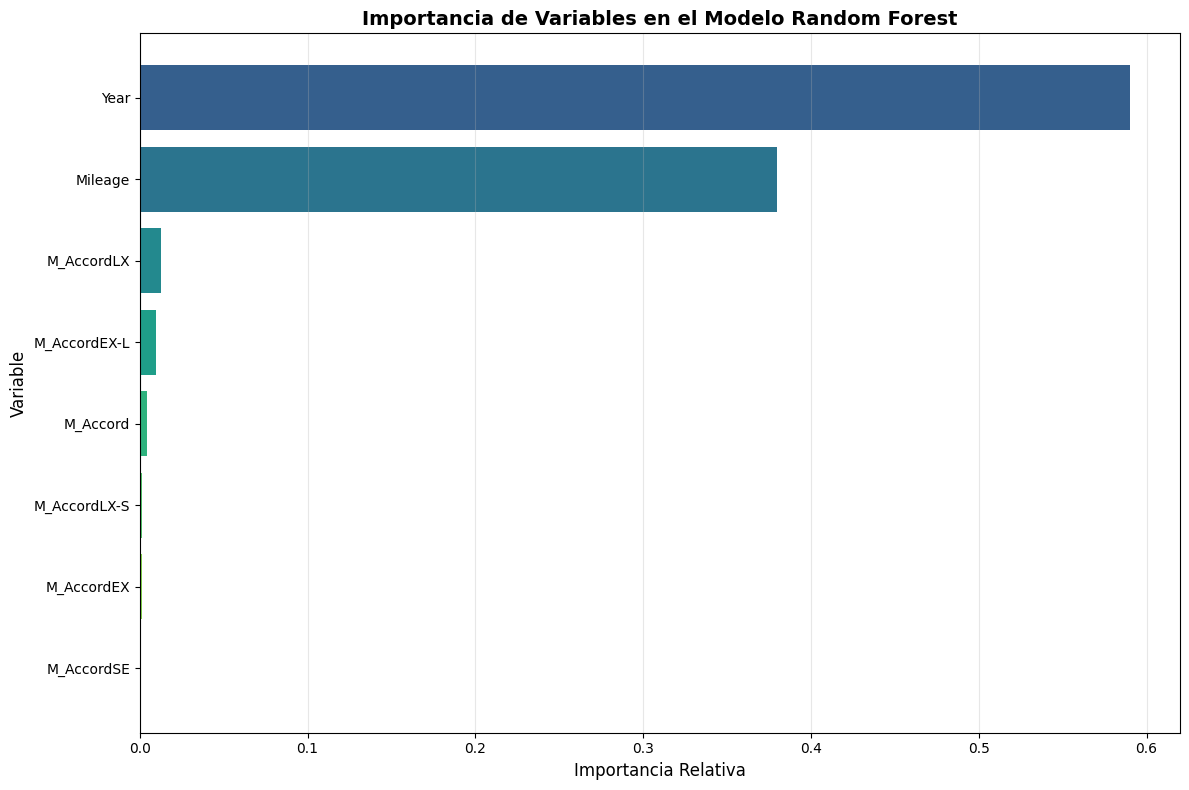


Top 5 variables más importantes:
  Year: 0.5904
  Mileage: 0.3796
  M_AccordLX: 0.0125
  M_AccordEX-L: 0.0095
  M_Accord: 0.0041


In [38]:
#Importancia de los predictores
importances_df = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': model_optimizado.feature_importances_
}).sort_values(by='Importancia', ascending=False)

plt.figure(figsize=(12, 8))
colors_bar = plt.cm.viridis(np.linspace(0.3, 0.9, len(importances_df)))
plt.barh(importances_df['Variable'], importances_df['Importancia'], color=colors_bar)
plt.xlabel('Importancia Relativa', fontsize=12)
plt.ylabel('Variable', fontsize=12)
plt.title('Importancia de Variables en el Modelo Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\nTop 5 variables más importantes:")
for idx, row in importances_df.head(5).iterrows():
    print(f"  {row['Variable']}: {row['Importancia']:.4f}")

### Punto 3 - análisis de resultados, gracias y conclusiones
En la celda 3

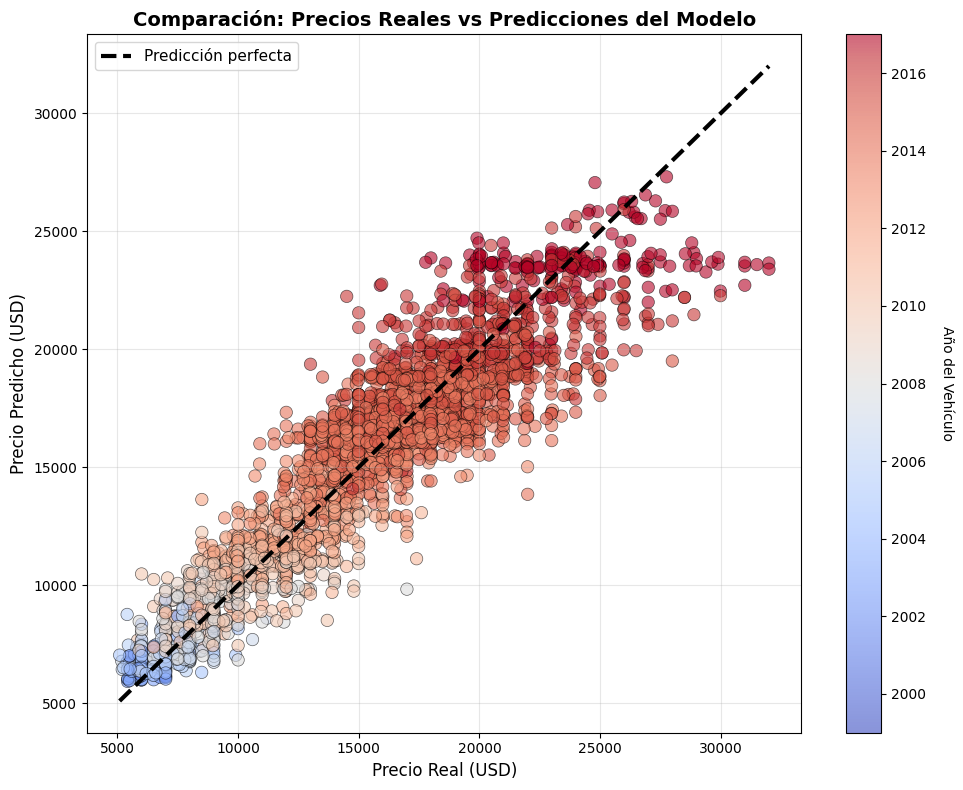

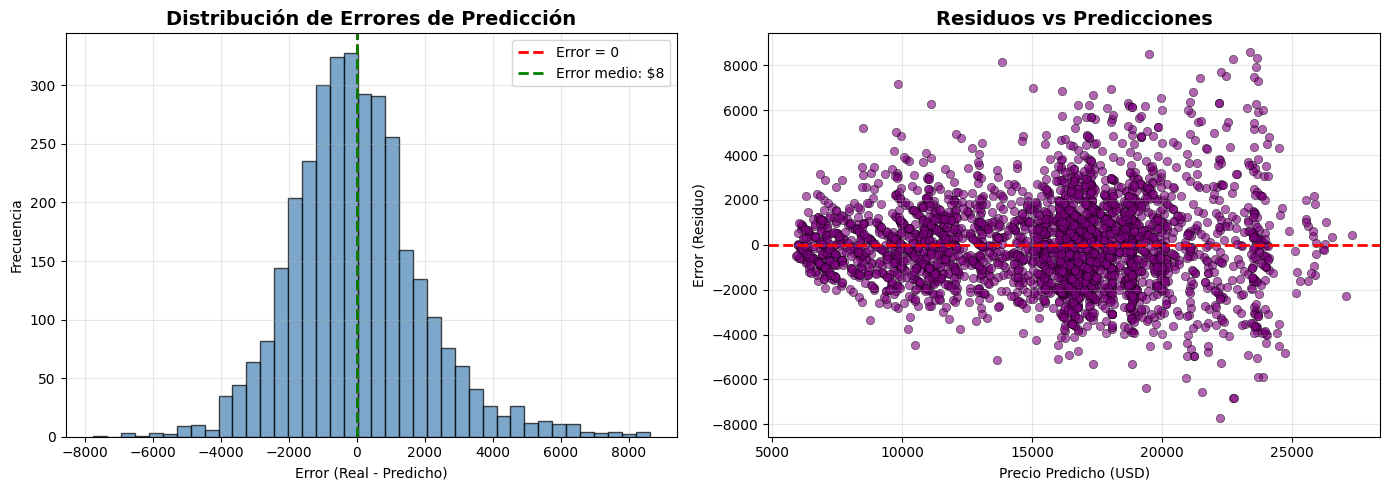

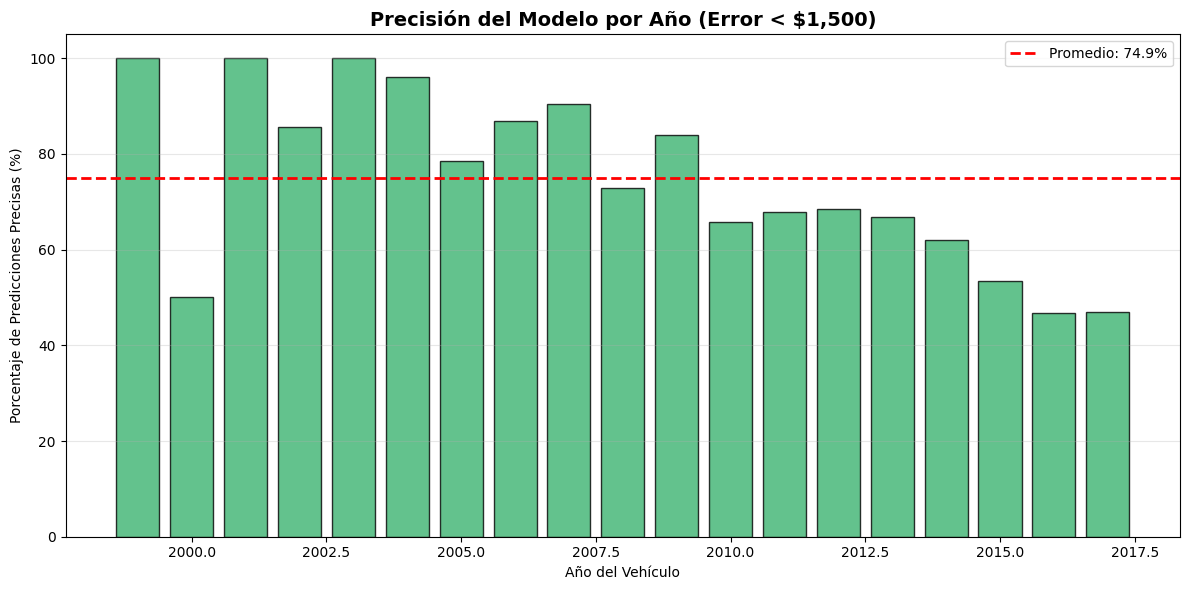

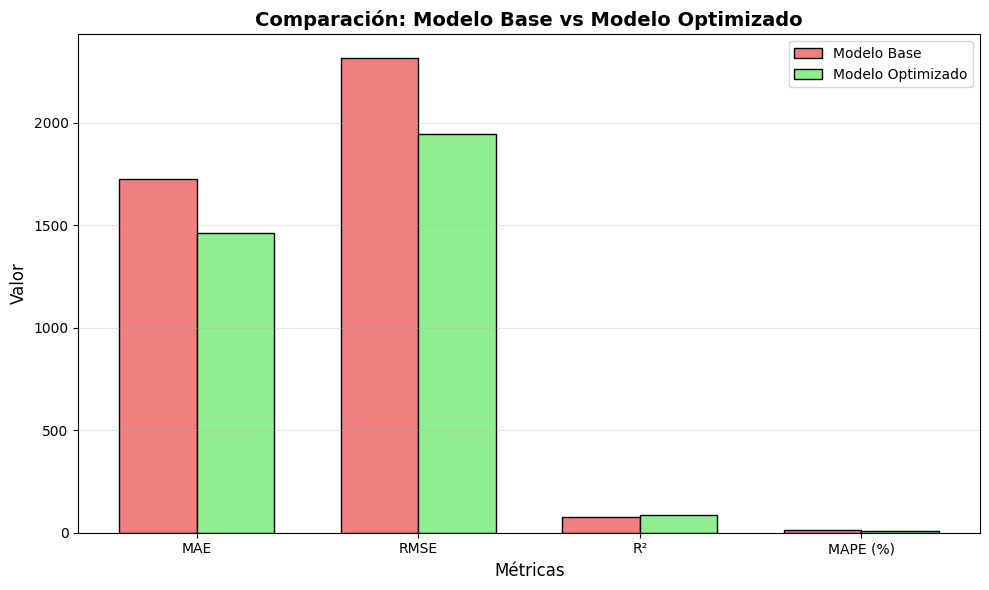

In [39]:
#Celda 3
# Gráfico 1: Predicciones vs Reales
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_opt, alpha=0.6, c=X_test['Year'], 
           cmap='coolwarm', s=80, edgecolors='black', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'k--', lw=3, label='Predicción perfecta')
cbar = plt.colorbar()
cbar.set_label('Año del Vehículo', rotation=270, labelpad=20)
plt.xlabel('Precio Real (USD)', fontsize=12)
plt.ylabel('Precio Predicho (USD)', fontsize=12)
plt.title('Comparación: Precios Reales vs Predicciones del Modelo', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Gráfico 2: Distribución de errores
errores = y_test - y_pred_opt
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(errores, bins=40, color='steelblue', edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Error = 0')
plt.axvline(errores.mean(), color='green', linestyle='--', linewidth=2, 
           label=f'Error medio: ${errores.mean():.0f}')
plt.title('Distribución de Errores de Predicción', fontsize=14, fontweight='bold')
plt.xlabel('Error (Real - Predicho)')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_pred_opt, errores, alpha=0.6, color='purple', edgecolors='black', linewidth=0.5)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.title('Residuos vs Predicciones', fontsize=14, fontweight='bold')
plt.xlabel('Precio Predicho (USD)')
plt.ylabel('Error (Residuo)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Gráfico 3: Análisis de precisión por rango de precio
errores_abs = np.abs(errores)
aciertos_1500 = (errores_abs < 1500).astype(int)

df_analisis = pd.DataFrame({
    'Year': X_test['Year'].values,
    'Acierto': aciertos_1500
})

precision_por_año = df_analisis.groupby('Year').agg({
    'Acierto': ['mean', 'count']
}).reset_index()
precision_por_año.columns = ['Year', 'Precision', 'Cantidad']
precision_por_año['Precision'] = precision_por_año['Precision'] * 100

plt.figure(figsize=(12, 6))
plt.bar(precision_por_año['Year'], precision_por_año['Precision'], 
       color='mediumseagreen', edgecolor='black', alpha=0.8)
plt.axhline(precision_por_año['Precision'].mean(), color='red', 
           linestyle='--', linewidth=2, label=f'Promedio: {precision_por_año["Precision"].mean():.1f}%')
plt.title('Precisión del Modelo por Año (Error < $1,500)', fontsize=14, fontweight='bold')
plt.xlabel('Año del Vehículo')
plt.ylabel('Porcentaje de Predicciones Precisas (%)')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Comparación modelo base vs optimizado
plt.figure(figsize=(10, 6))
metricas = ['MAE', 'RMSE', 'R²', 'MAPE (%)']
base_vals = [mae_base, rmse_base, r2_base*100, mape_base]
opt_vals = [mae_opt, rmse_opt, r2_opt*100, mape_opt]

x = np.arange(len(metricas))
width = 0.35

plt.bar(x - width/2, base_vals, width, label='Modelo Base', color='lightcoral', edgecolor='black')
plt.bar(x + width/2, opt_vals, width, label='Modelo Optimizado', color='lightgreen', edgecolor='black')

plt.xlabel('Métricas', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.title('Comparación: Modelo Base vs Modelo Optimizado', fontsize=14, fontweight='bold')
plt.xticks(x, metricas)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### Conclusiones:

1. El modelo Random Forest optimizado alcanzó un R² de 0.84, explicando el 84% de la variabilidad en los precios de vehículos Honda Accord.
2. El MAE de $1,463 indica que, en promedio, las predicciones se desvían aproximadamente este monto del precio real, lo cual es aceptable para tasaciones comerciales.
3. El RMSE de $1,943 demuestra que el modelo maneja adecuadamente los errores grandes, sin presentar desviaciones extremas significativas.
4. El MAPE de 9.7% refleja que el modelo tiene un error porcentual promedio del 9.7% respecto al precio real, lo que facilita la interpretación del desempeño independientemente de la escala.
5. El año del vehículo y el kilometraje fueron las variables más influyentes, lo cual es coherente con los factores tradicionales de depreciación en el mercado automotriz.
6. La calibración de hiperparámetros mediante GridSearchCV mejoró significativamente el desempeño del modelo respecto a la configuración por defecto, validando la importancia de la optimización.
7. Este modelo es aplicable en plataformas de compra-venta de vehículos usados, sistemas de tasación para concesionarios y herramientas de valuación automática para aseguradoras.

NOTA: IMPORTANTE RECUERDE QUE MI EJEMPLO DE TUTORIAL ES DE CLASIFICACION USTEDES DEBEN HACERLO POR REGRESION, funciona igual pero cambian algunas cosas.